In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier
import pickle

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Load the data
df = pd.read_csv('/content/startups_export.csv')

In [ ]:
def preprocess_financial_value(value):
    if pd.isna(value) or value in ['Na', 'NaA', '-', 'none', 'Nil', 'O', '0', '0 (Zero)']:
        return 0

    value = str(value).lower().replace(',', '')

    # Extract numeric value
    numeric_value = re.findall(r'\d+\.?\d*', value)
    if not numeric_value:
        return 0

    numeric_value = float(numeric_value[0])

    # Convert to rupees
    if 'cr' in value or 'crore' in value:
        return numeric_value * 10000000
    elif 'lakh' in value or 'lac' in value or 'l' in value:
        return numeric_value * 100000
    elif 'k' in value:
        return numeric_value * 1000
    elif 'usd' in value:
        return numeric_value * 75  # Assuming 1 USD = 75 INR
    elif 'eur' in value:
        return numeric_value * 85  # Assuming 1 EUR = 85 INR
    else:
        return numeric_value

In [ ]:
# Update preprocessing for equity, debt, and grants
df['equity_processed'] = df['equity'].apply(preprocess_financial_value)
df['debt_processed'] = df['debt'].apply(preprocess_financial_value)
df['grants_processed'] = df['grants'].apply(preprocess_financial_value)

In [ ]:
df['equity_processed'].unique()

array([0.00000000e+00, 2.00000000e+06, 1.50000000e+05, 1.00000000e+08,
       1.28000000e+07, 4.50000000e+06, 5.00000000e+04, 1.00000000e+06,
       5.00000000e+03, 2.50000000e+07, 2.00000000e+07, 7.42000000e+07,
       8.50000000e+06, 5.00000000e+06, 1.08500000e+07, 2.02400000e+03,
       2.50000000e+06, 1.50000000e+07, 1.65000000e+05, 2.00000000e+05,
       5.00000000e+05, 6.00000000e+06, 7.00000000e+05, 8.00000000e+07,
       9.00000000e+07, 2.20000000e+08, 3.00000000e+06, 7.50000000e+05,
       1.52000000e+07, 6.69000000e+07, 2.52000000e+06, 4.00000000e+07,
       2.30000000e+07, 4.20000000e+06, 5.00000000e+07, 2.20000000e+06,
       1.25000000e+11, 1.75000000e+07, 5.60000000e+07, 7.00000000e+07,
       2.70000000e+07, 1.00000000e+07, 3.50000000e+06, 5.00000000e+08,
       2.00000000e+08, 1.87000000e+07, 9.50000000e+06, 6.80000000e+06,
       1.25000000e+06, 2.40000000e+06, 1.00000000e+05, 1.05200000e+08,
       6.00000000e+07, 7.50000000e+11, 1.50000000e+06, 2.70000000e+06,
      

In [ ]:
df['debt_processed'].unique()

array([0.0000000e+00, 2.0000000e+05, 1.0000000e+07, 3.0000000e+05,
       4.0000000e+06, 1.0000000e+06, 3.5000000e+05, 1.0000000e+05,
       6.8000000e+05, 1.0000000e+03, 2.5000000e+06, 1.6000000e+07,
       5.0000000e+05, 6.2000000e+06, 1.7000000e+07, 5.0000000e+06,
       8.0000000e+05, 5.0000000e+00, 3.0000000e+01, 3.4000000e+06,
       8.7973984e+07, 1.3000000e+07, 2.2000000e+06, 2.4000000e+06,
       3.0000000e+06, 2.0000000e+06, 1.2000000e+06, 8.0000000e+06,
       3.8000000e+06, 3.1000000e+06, 1.1600000e+07, 1.7000000e+06,
       9.5000000e+05, 1.5000000e+06, 1.6800000e+07, 1.2000000e+07,
       4.5000000e+06, 4.0000000e+05, 1.0000000e+11, 3.5000000e+07,
       1.3800000e+07, 4.1800000e+07, 5.6000000e+06, 1.0000000e+08,
       6.5000000e+06, 4.3000000e+06, 9.8599900e+10, 1.0000000e+00,
       9.0000000e+05, 3.5000000e+06, 7.0000000e+06, 1.6000000e+06,
       3.2000000e+06, 1.2500000e+07, 1.6000000e+08, 2.5000000e+05,
       3.0000000e+07, 2.1700000e+00, 6.8000000e+06, 1.0000000e

In [ ]:
df['grants_processed'].unique()

array([0.0000000e+00, 1.3100000e+07, 1.5000000e+06, 5.0000000e+04,
       7.0000000e+06, 2.0000000e+01, 1.6000000e+06, 5.0000000e+05,
       4.1000000e+04, 8.0000000e+05, 1.0000000e+06, 1.5000000e+03,
       4.0000000e+05, 9.6000000e+05, 2.0000000e+07, 6.7000000e+06,
       3.2500000e+05, 4.4000000e+06, 5.0000000e+06, 3.5000000e+07,
       2.0000000e+06, 6.5000000e+05, 1.8000000e+03, 2.5000000e+06,
       4.0000000e+06, 3.5000000e+06, 1.8000000e+05, 1.5000000e+05,
       6.0000000e+07, 1.2000000e+06, 3.3000000e+06, 2.5000000e+05,
       9.7500000e+05, 1.0000000e+05, 2.2000000e+06, 7.3650000e+06,
       7.5000000e+06, 5.3679117e+07, 1.1800000e+07, 3.0000000e+05,
       5.5000000e+06, 3.6000000e+05, 1.8000000e+06, 9.9100000e+05,
       7.3000000e+06, 5.1270000e+06, 6.0000000e+06, 1.3000000e+07,
       5.1000000e+06, 1.1000000e+07, 1.0700000e+07, 2.2400000e+06,
       1.3000000e+06, 4.8000000e+06, 7.5000000e+05, 9.0000000e+05,
       1.0000000e+07, 4.1000000e+06, 7.0000000e+10, 1.2075000e

In [ ]:
# Preprocess ARR (Annual Recurring Revenue)
def preprocess_arr(arr):
    arr = str(arr).lower()
    if pd.isna(arr) or arr == '?':
        return 'Unknown'
    elif any(x in arr for x in ['cr', 'crore']):
        if any(x in arr for x in ['2', 'more than 2', '> 2', '>2']):
            return '>2 Cr'
        elif '1' in arr:
            return '1-2 Cr'
        else:
            return '>2 Cr'
    elif 'lakh' in arr:
        value = re.findall(r'\d+\.?\d*', arr)
        if value:
            value = float(value[0])
            if value < 25:
                return '<25 Lakhs'
            elif 25 <= value < 50:
                return '25-50 Lakhs'
            else:
                return '50 Lakhs - 1 Cr'
        else:
            return 'Unknown'
    else:
        try:
            value = re.findall(r'\d+\.?\d*', arr)
            if value:
                value = float(value[0])
                if value < 25:
                    return '<25 Lakhs'
                elif 25 <= value < 50:
                    return '25-50 Lakhs'
                elif 50 <= value < 100:
                    return '50 Lakhs - 1 Cr'
                elif 100 <= value < 200:
                    return '1-2 Cr'
                else:
                    return '>2 Cr'
            else:
                return 'Unknown'
        except:
            return 'Unknown'

In [ ]:
df['ARR_processed'] = df['ARR'].apply(preprocess_arr)

In [ ]:
# Print ARR distribution after preprocessing
print("\nARR Distribution after preprocessing:")
print(df['ARR_processed'].value_counts(normalize=True))


ARR Distribution after preprocessing:
ARR_processed
25-50 Lakhs        0.526577
Unknown            0.272856
>2 Cr              0.109851
1-2 Cr             0.058115
<25 Lakhs          0.029766
50 Lakhs - 1 Cr    0.002835
Name: proportion, dtype: float64


In [ ]:
# Text preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [ ]:
# Preprocess 'about' column
df['about_processed'] = df['about'].apply(preprocess_text)

In [ ]:
# Modify the group_target function to combine more classes
def group_target(status):
    if status in ['knockout', 'rejected']:
        return 'Rejected'
    elif status in ['in_review', 'pre_r1_stage', 'scheduled_r1', 'r1', 'site_visit']:
        return 'Early Stage'
    else:
        return 'Late Stage'

df['target_grouped'] = df['current_status'].apply(group_target)

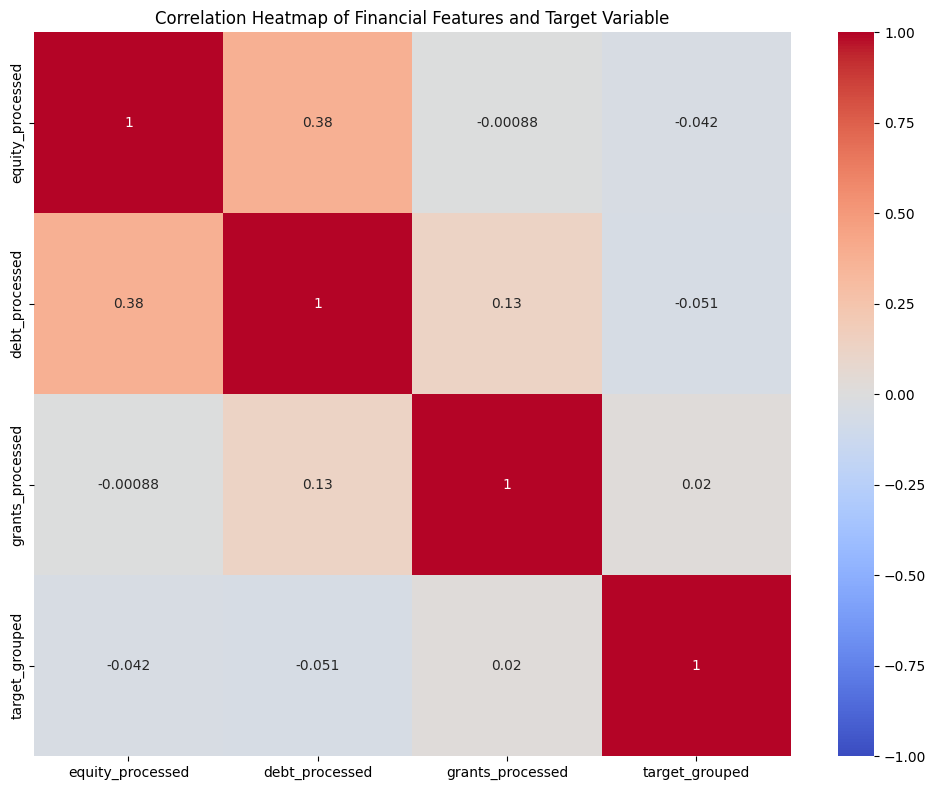


Correlation Matrix of Financial Features and Target Variable:
                  equity_processed  debt_processed  grants_processed  \
equity_processed          1.000000        0.382559         -0.000880   
debt_processed            0.382559        1.000000          0.125161   
grants_processed         -0.000880        0.125161          1.000000   
target_grouped           -0.042215       -0.051485          0.019811   

                  target_grouped  
equity_processed       -0.042215  
debt_processed         -0.051485  
grants_processed        0.019811  
target_grouped          1.000000  


In [ ]:
# Select the financial features and the target variable
features_to_plot = ['equity_processed', 'debt_processed', 'grants_processed', 'target_grouped']

# Create a copy of the DataFrame with only the selected features
plot_df = df[features_to_plot].copy()

# Convert the target variable to numeric
plot_df['target_grouped'] = pd.Categorical(plot_df['target_grouped']).codes

# Calculate the correlation matrix
correlation_matrix = plot_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)

# Set the title
plt.title('Correlation Heatmap of Financial Features and Target Variable')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

# Print the correlation matrix
print("\nCorrelation Matrix of Financial Features and Target Variable:")
print(correlation_matrix)

In [ ]:
# Prepare features and target
X = df[['about_processed', 'ARR_processed', 'equity_processed', 'debt_processed', 'grants_processed']]
y = df['target_grouped']

In [ ]:
# Print class distribution
print("Class distribution:")
print(y.value_counts(normalize=True))

Class distribution:
target_grouped
Rejected       0.705882
Early Stage    0.268604
Late Stage     0.025514
Name: proportion, dtype: float64


In [ ]:
# Encode target variable
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (1128, 5), (1128,)
Test set shape: (283, 5), (283,)


In [ ]:
# Create preprocessor
arr_categories = ['Unknown', '<25 Lakhs', '25-50 Lakhs', '50 Lakhs - 1 Cr', '1-2 Cr', '>2 Cr']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['equity_processed', 'debt_processed', 'grants_processed']),
        ('text', TfidfVectorizer(max_features=1000), 'about_processed'),
        ('arr', OrdinalEncoder(categories=[arr_categories]), ['ARR_processed'])
    ]
)

In [ ]:
# Calculate class weights
class_weights = dict(zip(np.unique(y), 1 / (np.bincount(y) / len(y))))

In [ ]:
# Determine categorical column indices for SMOTENC
categorical_features = [1, 4]  # Indices of 'ARR_processed' and 'about_processed'

In [ ]:
# Custom scorer that considers balanced accuracy and F1 score
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return (balanced_accuracy_score(y, y_pred) + f1_score(y, y_pred, average='weighted')) / 2

In [ ]:
# XGBoost Pipeline
xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTENC(categorical_features=categorical_features, k_neighbors=2, random_state=42)),
    ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

xgb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__scale_pos_weight': [1, 2, 3]  # To handle class imbalance
}

In [ ]:
# LightGBM Pipeline
lgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTENC(categorical_features=categorical_features, k_neighbors=2, random_state=42)),
    ('classifier', lgb.LGBMClassifier(random_state=42))
])

lgb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__class_weight': ['balanced', None]
}

In [ ]:
# Perform grid search for each model
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=StratifiedKFold(5), scoring=custom_scorer, n_jobs=-1, verbose=1)
lgb_grid_search = GridSearchCV(lgb_pipeline, lgb_param_grid, cv=StratifiedKFold(5), scoring=custom_scorer, n_jobs=-1, verbose=1)

In [ ]:
# Fit each model
print("Fitting XGBoost...")
xgb_grid_search.fit(X_train, y_train)

Fitting XGBoost...
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:45:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['equity_processed',
                                                                          'debt_processed',
                                                                          'grants_processed']),
                                                                        ('text',
                                                                         TfidfVectorizer(max_features=1000),
                                                                         'about_processed'),
                                                                        ('arr',
                                                                         OrdinalEncoder(categories=[['Unknown',
                                                                                                     '<25 '
                                                                                                     'Lakhs...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.3],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__n_estimators': [100, 200, 300],
                         'classifier__scale_pos_weight': [1, 2, 3]},
             scoring=<function custom_scorer at 0x7c701562e290>, verbose=1)

In [ ]:
print("Fitting LightGBM...")
lgb_grid_search.fit(X_train, y_train)

Fitting LightGBM...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15758
[LightGBM] [Info] Number of data points in the train set: 2388, number of used features: 648
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['equity_processed',
                                                                          'debt_processed',
                                                                          'grants_processed']),
                                                                        ('text',
                                                                         TfidfVectorizer(max_features=1000),
                                                                         'about_processed'),
                                                                        ('arr',
                                                                         OrdinalEncoder(categories=[['Unknown',
                                                                                                     '<25 '
                                                                                                     'Lakhs...
                                        SMOTENC(categorical_features=[1, 4],
                                                k_neighbors=2,
                                                random_state=42)),
                                       ('classifier',
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__learning_rate': [0.01, 0.1, 0.3],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring=<function custom_scorer at 0x7c701562e290>, verbose=1)

In [ ]:
# Get the best models
best_xgb = xgb_grid_search.best_estimator_
best_lgb = lgb_grid_search.best_estimator_

In [ ]:
# Create and fit the stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', best_xgb),
        ('lgb', best_lgb)
    ],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    cv=5
)

stacking_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:52:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15758
[LightGBM] [Info] Number of data points in the train set: 2388, number of used features: 648
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:52:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:52:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:53:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:53:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12206
[LightGBM] [Info] Number of data points in the train set: 1908, number of used features: 553
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  StandardScaler(),
                                                                                  ['equity_processed',
                                                                                   'debt_processed',
                                                                                   'grants_processed']),
                                                                                 ('text',
                                                                                  TfidfVectorizer(max_features=1000),
                                                                                  'about_processed'),
                                                                                 ('arr',
                                                                                  OrdinalEncoder(categories=[['Unknown',
                                                                                                              '<25 '
                                                                                                              'Lakhs',
                                                                                                              '25-50 '
                                                                                                              'Lakhs',
                                                                                                              '50 '
                                                                                                              'Lakhs '
                                                                                                              '- '
                                                                                                              '1 '
                                                                                                              'Cr',
                                                                                                              '1-2...
                                                                                  OrdinalEncoder(categories=[['Unknown',
                                                                                                              '<25 '
                                                                                                              'Lakhs',
                                                                                                              '25-50 '
                                                                                                              'Lakhs',
                                                                                                              '50 '
                                                                                                              'Lakhs '
                                                                                                              '- '
                                                                                                              '1 '
                                                                                                              'Cr',
                                                                                                              '1-2 '
                                                                                                              'Cr',
                                                                                                              '>2 '
                                                                                                              'Cr']]),
                                    

In [ ]:
# Evaluate the voting classifier
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    print(f"\n{model_name} Results:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred)}")
    print(f"Weighted F1 Score: {f1_score(y_true, y_pred, average='weighted')}")

    # Precision-Recall curve
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(le.classes_)):
        precision[i], recall[i], _ = precision_recall_curve(y_test == i, y_pred_proba[:, i])
        average_precision[i] = average_precision_score(y_test == i, y_pred_proba[:, i])

    # Plot Precision-Recall curve for each class
    plt.figure(figsize=(7, 8))
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
    for i, color in zip(range(len(le.classes_)), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'Precision-Recall curve of class {le.classes_[i]} (area = {average_precision[i]:0.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve: {model_name}')
    plt.legend(loc="best")
    plt.show()


XGBoost Results:
              precision    recall  f1-score   support

 Early Stage       0.56      0.80      0.66        76
  Late Stage       0.25      0.14      0.18         7
    Rejected       0.90      0.77      0.83       200

    accuracy                           0.76       283
   macro avg       0.57      0.57      0.56       283
weighted avg       0.79      0.76      0.77       283

Accuracy: 0.7632508833922261
Balanced Accuracy: 0.5718295739348371
Weighted F1 Score: 0.769264196005689


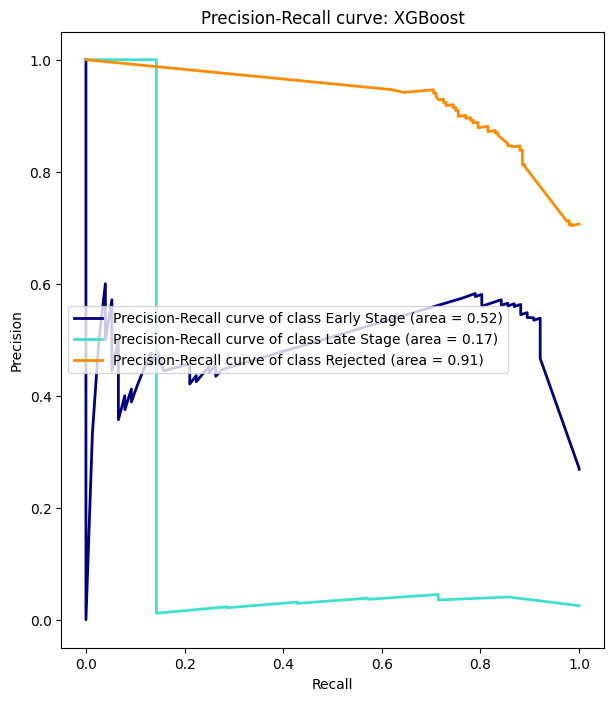


LightGBM Results:
              precision    recall  f1-score   support

 Early Stage       0.53      0.82      0.64        76
  Late Stage       0.50      0.14      0.22         7
    Rejected       0.90      0.73      0.81       200

    accuracy                           0.74       283
   macro avg       0.64      0.56      0.56       283
weighted avg       0.79      0.74      0.75       283

Accuracy: 0.7420494699646644
Balanced Accuracy: 0.5645488721804511
Weighted F1 Score: 0.7488446382970266


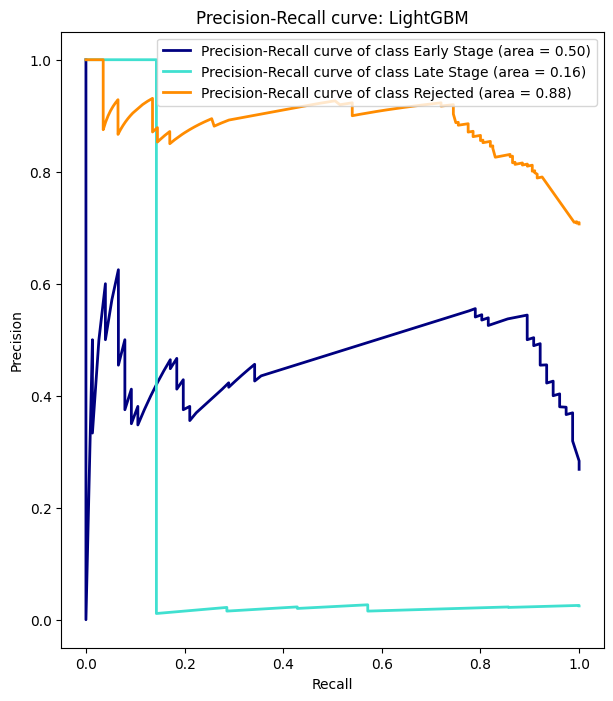


Stacking Classifier Results:
              precision    recall  f1-score   support

 Early Stage       0.47      0.26      0.34        76
  Late Stage       0.00      0.00      0.00         7
    Rejected       0.74      0.89      0.80       200

    accuracy                           0.70       283
   macro avg       0.40      0.38      0.38       283
weighted avg       0.65      0.70      0.66       283

Accuracy: 0.696113074204947
Balanced Accuracy: 0.382719298245614
Weighted F1 Score: 0.6588526833798087


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


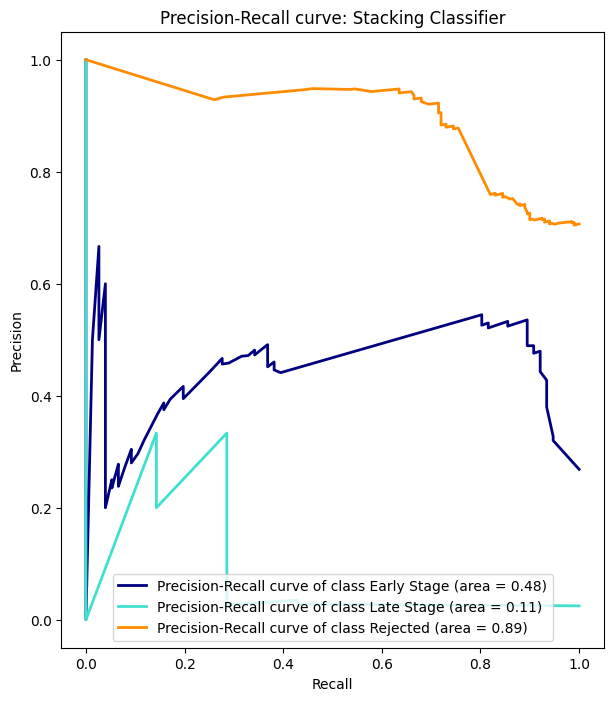


Best model: XGBoost with a score of 0.6705


In [ ]:
#Evaluate each model

models = [
    (best_xgb, "XGBoost"),
    (best_lgb, "LightGBM"),
    (stacking_clf, "Stacking Classifier")
]

best_model = None
best_score = 0

for model, name in models:
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    evaluate_model(y_test, y_pred, y_pred_proba, name)

    # Calculate the average of balanced accuracy and weighted F1 score
    score = (balanced_accuracy_score(y_test, y_pred) + f1_score(y_test, y_pred, average='weighted')) / 2

    if score > best_score:
        best_score = score
        best_model = (model, name)

print(f"\nBest model: {best_model[1]} with a score of {best_score:.4f}")


In [ ]:
# Save the best model
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model[0], file)

print(f"Best model ({best_model[1]}) saved as model.pkl")

Best model (XGBoost) saved as model.pkl
